In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import KFold

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

#tf.debugging.set_log_device_placement(True)

print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.0.0


In [2]:
train_data = pd.read_csv('../input/train_x.csv', index_col=0, header=None)
train_labels = pd.read_csv('../input/train_y.csv', index_col=0)
test_data = pd.read_csv('../input/test_x.csv', index_col=0, header=None)

In [3]:
train_data.shape, train_labels.shape, test_data.shape

((7200, 3072), (7200, 1), (4800, 3072))

In [4]:
train_data

,1,2,3,4,5,6,7,8,9,10,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,,,,,,,,,,,,,,,,,,,,,
0,148,159,177,145,157,174,145,157,174,146,...,193,237,211,199,232,204,195,223,203,195
1,225,225,225,225,225,225,219,219,219,216,...,252,253,254,254,248,250,251,228,232,235
2,133,119,79,179,146,117,167,121,99,115,...,87,114,163,71,128,186,98,117,175,90
3,83,102,62,88,108,68,87,108,69,82,...,21,9,18,22,12,20,25,16,21,26
4,97,100,98,94,98,91,96,97,91,108,...,120,96,106,122,98,109,124,109,120,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,117,154,180,116,152,178,116,152,178,116,...,178,116,152,178,116,152,178,117,154,180
7196,254,254,254,252,252,252,253,253,253,252,...,255,255,255,255,254,254,254,255,255,255
7197,160,160,160,161,161,161,162,162,162,158,...,174,177,177,177,172,172,172,170,170,170


In [5]:
test_data

,1,2,3,4,5,6,7,8,9,10,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,,,,,,,,,,,,,,,,,,,,,
0,235,215,190,227,204,178,215,190,162,194,...,223,252,243,231,253,244,233,252,245,234
1,29,44,37,45,72,51,50,80,52,58,...,16,43,38,30,79,80,76,123,122,123
2,38,51,33,44,59,38,49,67,40,58,...,37,75,74,54,78,77,57,70,69,49
3,136,169,206,133,171,211,138,172,208,167,...,94,198,158,97,209,169,107,200,157,104
4,153,136,117,160,136,111,175,144,114,174,...,75,111,97,68,115,94,71,106,93,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,35,40,38,49,53,52,59,64,60,36,...,96,138,156,99,137,152,96,147,158,105
4796,237,231,195,237,232,190,236,231,190,238,...,87,209,175,103,226,193,124,217,186,122
4797,109,156,237,109,156,239,110,156,240,111,...,252,182,199,251,187,201,250,192,205,251


In [6]:
train_labels

,target
0,1
1,0
2,0
3,0
4,0
...,...
7195,0
7196,0
7197,1
7198,1


In [7]:
# Check classes balance

train_labels['target'].value_counts()

0    3605
1    3595
Name: target, dtype: int64

In [8]:
# Convert to numpy arrays

train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

train_labels = train_labels.to_numpy()

In [9]:
def get_sample_image(sample):
    image = sample.reshape(32, 32, 3)
    return image

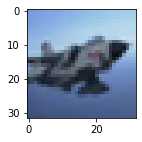

In [10]:
# Sample image

plt.figure(figsize=(2, 2))
plt.imshow(get_sample_image(train_data[555]))
plt.show()

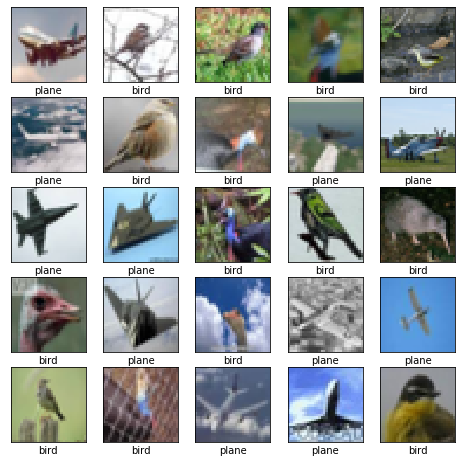

In [11]:
# Sample images 

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(get_sample_image(train_data[i]))
    plt.xlabel('plane' if train_labels[i] else 'bird')
plt.show()

In [12]:
# Normalize and reshape to 32 x 32 x 3 (RGB)

train_data = train_data / 255
train_data = train_data.reshape(train_data.shape[0], 32, 32, 3)

In [13]:
# Convolutional NN

def build_model():
    
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Training with KFold validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

epochs_num = 150
all_loss = []
all_accuracy = []

i = 0
for train_index, val_index in kf.split(train_data):
    i += 1
    print('Processing fold #', i)
    
    X_train = train_data[train_index] 
    y_train = train_labels[train_index]

    X_val = train_data[val_index]
    y_val = train_labels[val_index]
    
    model = build_model()
    history = model.fit(X_train, y_train,
                        epochs=epochs_num, 
                        batch_size=128,
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    loss_history = history.history['val_loss']
    all_loss.append(loss_history)

    accuracy_history = history.history['val_accuracy']
    all_accuracy.append(accuracy_history)

Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4
Processing fold # 5


In [15]:
# Exponential moving average function

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

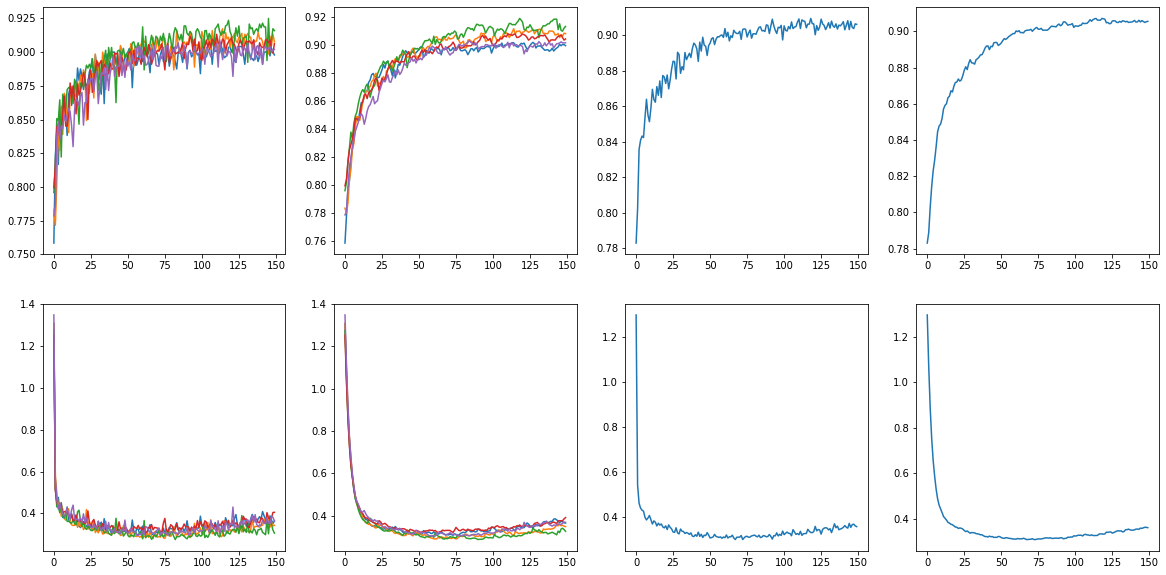

In [16]:
# Plots

n_from = 0
n_to = epochs_num
    
plt.figure(figsize=(20, 10))

# Accuracy plots
plt.subplot(2, 4, 1)
for i in range(5):
    sns.lineplot(np.arange(n_to - n_from), all_accuracy[i][n_from:n_to]);

plt.subplot(2, 4, 2)
for i in range(5):
    sns.lineplot(np.arange(n_to - n_from), smooth_curve(all_accuracy[i][n_from:n_to], factor=0.7));

plt.subplot(2, 4, 3)
all_accuracy_np = np.array(all_accuracy)
sns.lineplot(np.arange(n_to - n_from), all_accuracy_np.mean(axis=0)[n_from:n_to]);

plt.subplot(2, 4, 4)
sns.lineplot(np.arange(n_to - n_from), smooth_curve(all_accuracy_np.mean(axis=0)[n_from:n_to], factor=0.7));

# Loss plots
plt.subplot(2, 4, 5)
for i in range(5):
    sns.lineplot(np.arange(n_to - n_from), all_loss[i][n_from:n_to]);

plt.subplot(2, 4, 6)
for i in range(5):
    sns.lineplot(np.arange(n_to - n_from), smooth_curve(all_loss[i][n_from:n_to], factor=0.7));

plt.subplot(2, 4, 7)
all_loss_np = np.array(all_loss)
sns.lineplot(np.arange(n_to - n_from), all_loss_np.mean(axis=0)[n_from:n_to]);

plt.subplot(2, 4, 8)
sns.lineplot(np.arange(n_to - n_from), smooth_curve(all_loss_np.mean(axis=0)[n_from:n_to], factor=0.7));

plt.show()

In [17]:
# Final train

epochs_num = 75

X_train = train_data
y_train = train_labels

model = build_model()
model.fit(X_train, y_train, epochs=epochs_num, batch_size=128, verbose=0);

In [18]:
# Normalize and reshape to 32 x 32 x 3 (RGB)

X_test = test_data / 255
X_test = X_test.reshape(test_data.shape[0], 32, 32, 3)

In [43]:
# Make Predictions

y_pred = model.predict(X_test)

y_pred[:10]

array([[0.00838825],
       [0.00989035],
       [0.21900347],
       [0.997286  ],
       [0.99907947],
       [0.03120723],
       [0.9975206 ],
       [0.9983326 ],
       [0.01660648],
       [0.99885046]], dtype=float32)

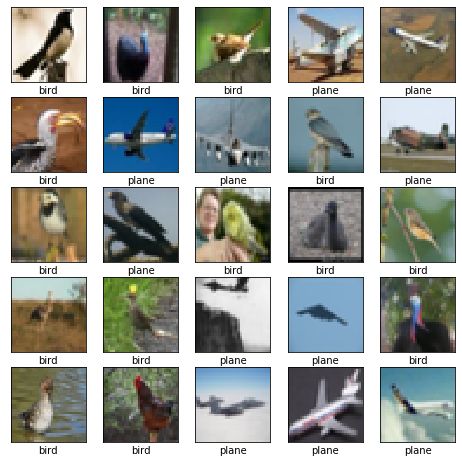

In [44]:
# Show some predictions

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(get_sample_image(test_data[i]))
    plt.xlabel('plane' if y_pred[i] >= 0.5 else 'bird')
plt.show()

In [39]:
# Make submission

submission = pd.DataFrame({'id': range(test_data.shape[0]),
                           'target': (y_pred >= 0.5).astype('int').flatten()
                          })

In [47]:
submission.tail(3)

,id,target
4797,4797,1
4798,4798,1
4799,4799,0


In [42]:
submission.to_csv('submission.csv', index=False)